In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np

from readers import reader
from config import RECORDING_FILE

In [3]:
NPreader = reader.NeuropixelsReader(RECORDING_FILE)
channels = [0, 1, 2]  # Example channels
start_times = [0, 1000]  # Start times in ms
window=100 #  in ms
conv_to_uv=True
data, time = NPreader.read_data(channels, start_times, window, convert_to_uv=conv_to_uv)

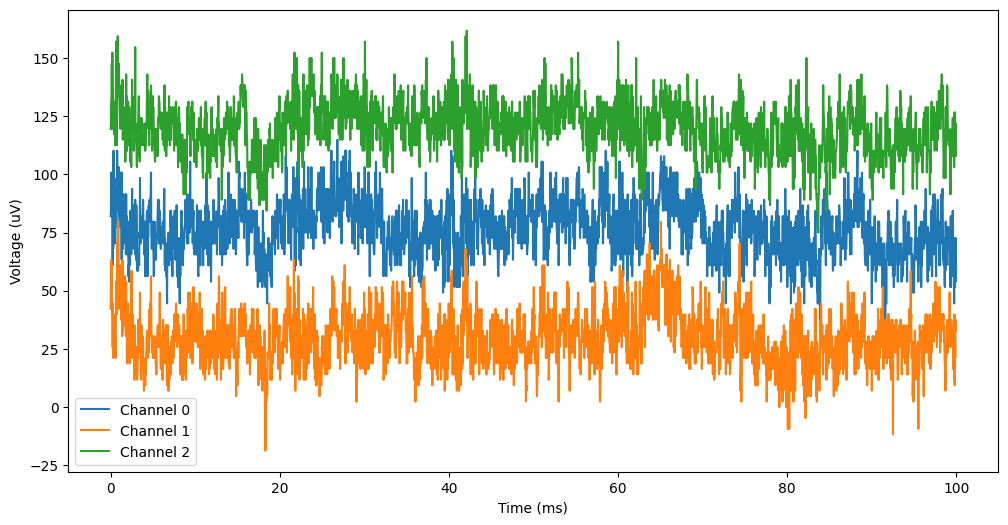

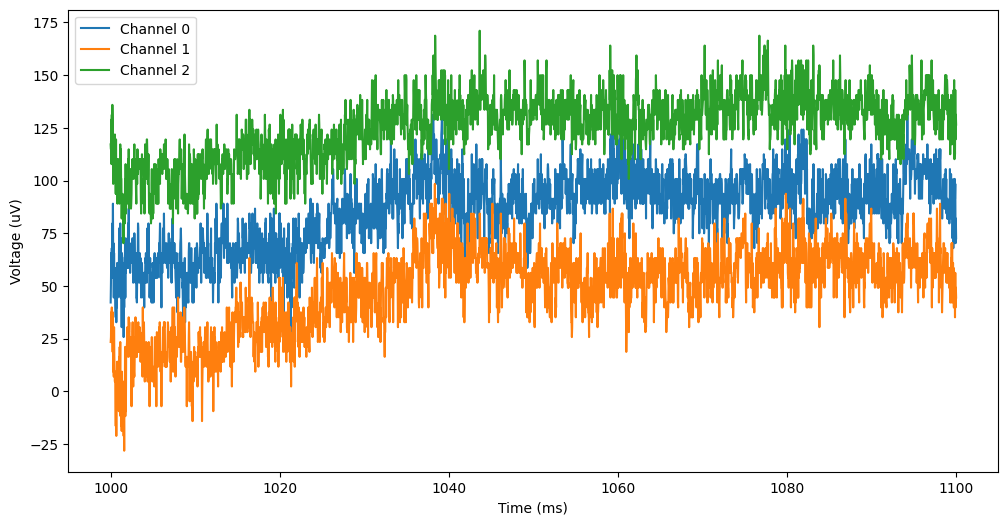

In [11]:
for j in range(data.shape[0]):

    fig, ax = plt.subplots(figsize=(12, 6))
    for i in range(data.shape[1]):
        ax.plot(time[j], data[j, i, :], label=f'Channel {channels[i]}')

    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Voltage (uV)' if conv_to_uv else 'Raw value')

    ax.legend()

    plt.show()